**El método TreeExplainer**

Como el método Explainer es muy costoso computacionalmente para datasets muy grandes, Scott Lundherg y Su-In Lee, crearon un tiempo despues el método TreeExplainer que es unicamente para algoritmo basados en árboles de decisión.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
!pip install shap

In [ ]:
import shap  # package used to calculate Shap values

In [ ]:
pd.set_option("display.max_columns", 30)
data = pd.read_csv('/content/FIFA 2018 Statistics.csv')
data.sample(3)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
80,27-06-2018,Korea Republic,Germany,2,30,11,5,5,1,3,0,8,7,74,237,118,16,4,0,0,Yes,90.0,Group Stage,No,0,NaN,NaN
49,22-06-2018,Iceland,Nigeria,0,42,10,3,6,1,5,0,10,2,75,291,106,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN


In [ ]:
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
X.sample(5)

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
90,0,43,8,3,4,1,1,3,18,1,78,281,97,15,1,0,0,0
105,0,53,13,1,4,8,7,2,6,8,85,424,89,18,4,0,0,0
113,2,58,11,2,7,2,3,0,17,4,81,524,99,15,2,0,0,0
96,4,41,9,4,4,1,0,0,16,1,84,351,97,21,3,0,0,0
26,1,41,6,1,3,2,2,2,11,5,82,326,103,14,0,0,0,0


Para el análisis de Shap values, nos quedaremos con los casos donde el equipo tuvo la figura del partido para poder ver y explicar cuales son las variables que más contribuyen a que un equipo obtenga el "Man of the Match"

Además, nos quedaremos con las variables numéricas ya que el método shap no admite variables categóricas (al menos sin preprocesamiento).

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [ ]:
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)
my_model

RandomForestClassifier(random_state=0)

In [ ]:
val_X.head(2)


,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
121,0,60,9,3,5,1,5,1,7,4,90,629,102,16,3,0,0,0
104,2,47,21,10,7,4,8,0,20,1,83,398,92,6,2,0,0,0


In [ ]:
data.columns.to_list()

**Implementación**

In [ ]:
# reo el objeto que calculo los valores shapley
explainer = shap.TreeExplainer(my_model)
explainer

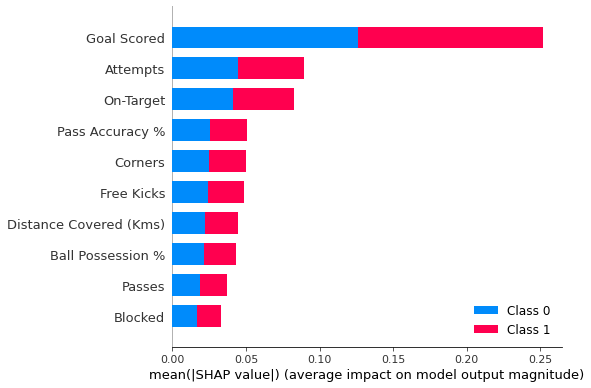

In [ ]:
# Calculo de los valores Shap
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, max_display=10)

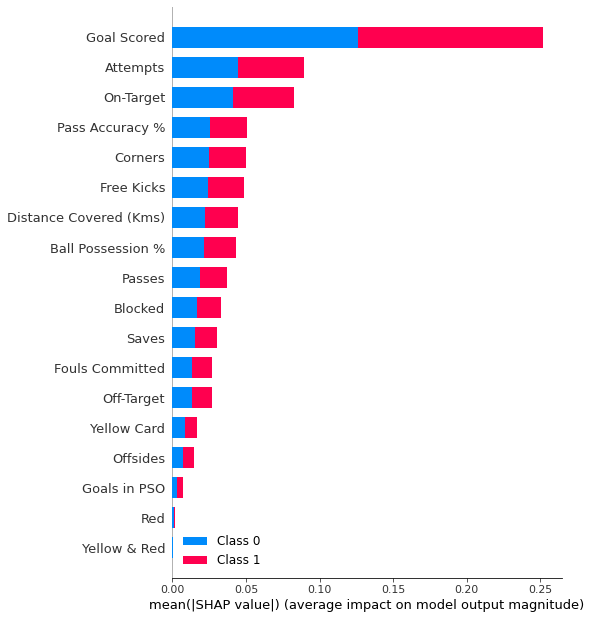

In [ ]:
shap.summary_plot(shap_values, X)

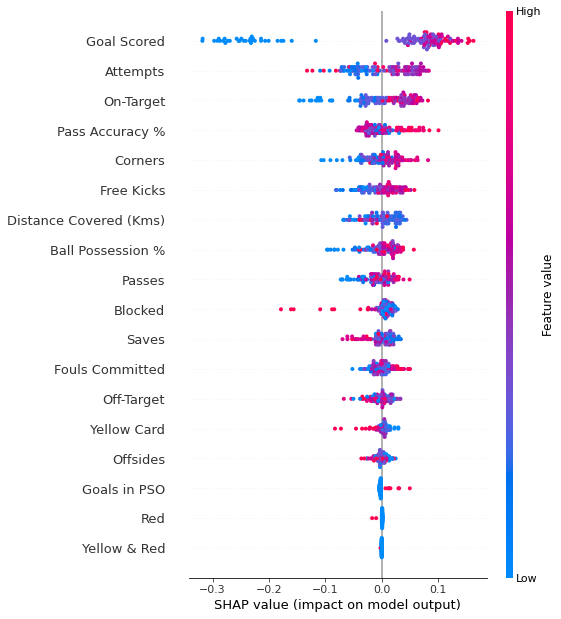

In [ ]:
shap.summary_plot(shap_values[1], X)

**Gráfico de dependencias**

In [ ]:
vars_graficar = ["Attempts", "On-Target", "Pass Accuracy %"]

*** shap.dependence_plot for Goal Scored with interaction_index  Attempts


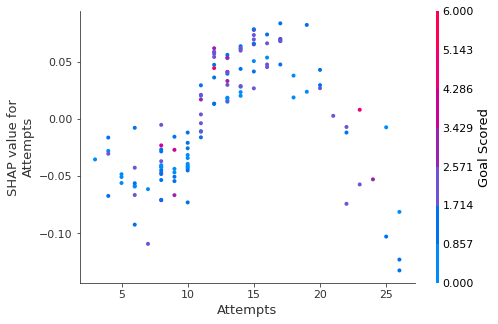

*** shap.dependence_plot for Goal Scored with interaction_index  On-Target


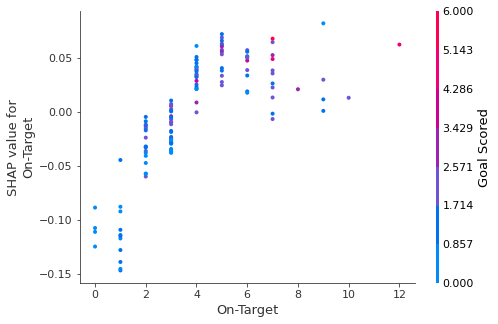

*** shap.dependence_plot for Goal Scored with interaction_index  Pass Accuracy %


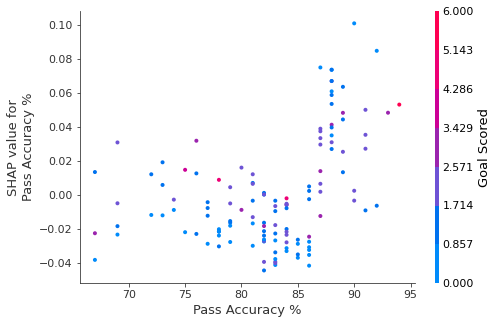

In [ ]:
for feature in vars_graficar:
    print('*** shap.dependence_plot for Goal Scored with interaction_index ', feature)
    shap.dependence_plot(feature, shap_values[1], X, interaction_index="Goal Scored")

**Explicacion de un solo ejemplo**

Podemos ver como es el impacto de cada variable para una predicción en particular.

**Force Plot**

In [ ]:
#En caso de querer usar xgboost
import xgboost
dtrain = xgboost.DMatrix(train_X, label=train_y)
dtest = xgboost.DMatrix(val_X, label=val_y)
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(train_X, label=train_y), 100)

In [ ]:
# Calculate Shap values
shap_values = explainer.shap_values(X)

In [ ]:
i=0
shap.initjs() # debe iniciarse ya que es una visualizacion de JavaScript
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], link="logit")

In [ ]:
sample = X.iloc[[i]].T
sample['Shap Values'] = shap_values[i].round(2)
sample['Shap Values Abs'] = sample['Shap Values'].abs()
sample.sort_values('Shap Values Abs', ascending=False).drop('Shap Values Abs', axis=1)

,0,Shap Values
Goal Scored,5,2.28
Ball Possession %,40,-0.60
Distance Covered (Kms),118,-0.39
Off-Target,3,0.26
Passes,306,0.20
Offsides,3,0.18
Attempts,13,-0.08
Fouls Committed,22,-0.07
Saves,0,-0.07
Corners,6,0.05


**Waterfall Plot**

In [ ]:
model = xgboost.XGBClassifier().fit(X, y)
# Creo el objeto que calculo los shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

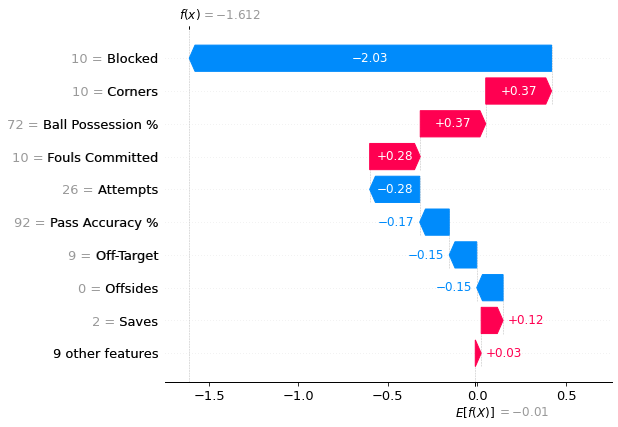

In [ ]:
shap.plots.waterfall(shap_values[10])

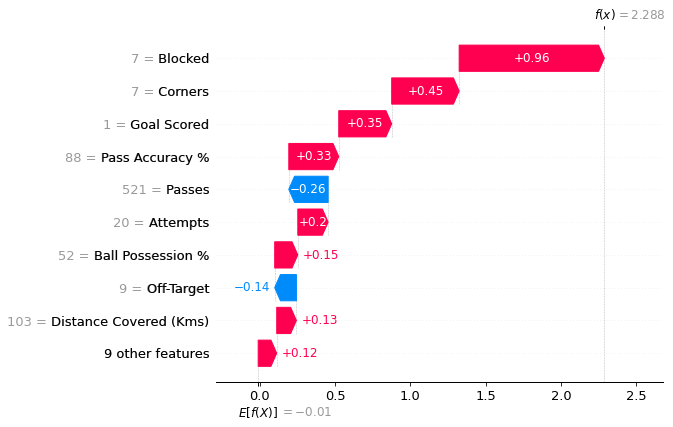

In [ ]:
shap.plots.waterfall(shap_values[20])

In [ ]:
import xgboost
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

In [ ]:
X.shape


(506, 13)

In [ ]:
explainer2 = shap.TreeExplainer(model)
shap_values2 = explainer2.shap_values(X)
shap_values2

array([[ 2.1455370e-01,  1.3466646e-03,  1.8625211e-02, ...,
         5.0436582e-02,  2.7335213e-02,  3.9443178e+00],
       [ 1.5532921e-01, -1.4507028e-04,  1.5379549e-02, ...,
         6.7537025e-02,  3.0773303e-02,  1.7763227e+00],
       [ 2.1507122e-01, -1.9673388e-04,  1.0975994e-02, ...,
         5.9503976e-02,  4.0971912e-02,  4.0798807e+00],
       ...,
       [ 2.0547199e-01, -3.6510420e-03,  1.0617593e-02, ...,
        -1.1088923e+00,  3.1912204e-02,  2.0818517e+00],
       [ 2.3516524e-01, -3.6303336e-03,  1.7462406e-02, ...,
        -2.8561923e-01,  2.8462764e-02,  2.2705686e+00],
       [ 3.9219104e-02, -2.8915398e-02,  1.4358116e-02, ...,
        -3.4452000e-01,  2.7025474e-02,  1.1188300e+00]], dtype=float32)

In [ ]:
# visualize the training set predictions
shap.initjs()

shap.force_plot(explainer2.expected_value, shap_values2, X)

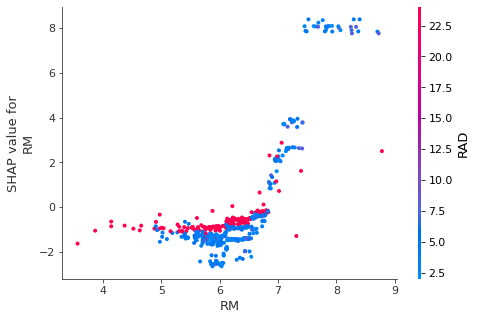

In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values2, X)

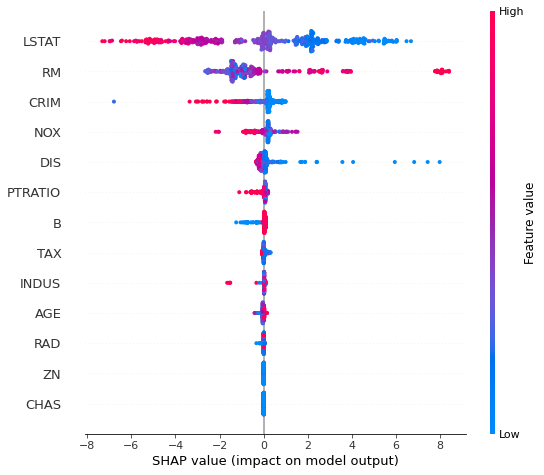

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values2, X)

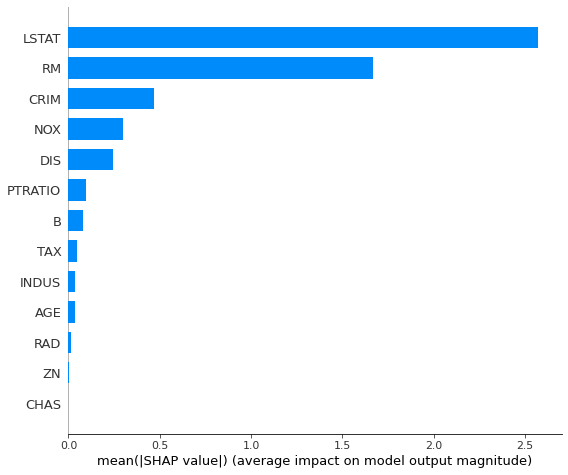

In [ ]:
shap.summary_plot(shap_values2, X, plot_type="bar")


In [ ]:
val_X.shape


(32, 18)

In [ ]:
shap_values = explainer.shap_values(val_X)
shap_values

In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_values[1], val_X)


In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value[0], shap_values[0], val_X)
